In [1]:
from web3 import Web3
import requests

In [3]:
import seaborn as sn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
w3 = Web3(Web3.HTTPProvider("https://api.avax.network/ext/bc/C/rpc"))

lb_proxy = Web3.toChecksumAddress("0xee5A90098b270596Ec35D637b30d908C862c86df")
abi=requests.get(f"https://api.snowtrace.io/api?module=contract&action=getabi&address={lb_proxy}").json()['result']

In [15]:
lb_impl = Web3.toChecksumAddress("0xD446eb1660F766d533BeCeEf890Df7A69d26f7d1")
contract = w3.eth.contract(address=lb_impl, abi=abi)

In [10]:
def get_decimals(address):
    abi=requests.get(f"https://api.snowtrace.io/api?module=contract&action=getabi&address={Web3.toChecksumAddress(address)}").json()['result']

    contract = w3.eth.contract(address=address, abi=abi)
    return contract.functions.decimals().call()

In [16]:
tokenX = contract.functions.getTokenX().call()
tokenY = contract.functions.getTokenY().call()

In [38]:
active_bin = contract.functions.getActiveId().call()
left_bins = [contract.functions.getNextNonEmptyBin(True, active_bin).call()]
right_bins = [contract.functions.getNextNonEmptyBin(False, active_bin).call()]


In [39]:
while True:
    next_bin = contract.functions.getNextNonEmptyBin(True, left_bins[0]).call()
    if next_bin > left_bins[0]:
        break
    else:
        left_bins.insert(0, next_bin)

print("Found all USDC bins, looking for AVAX bins...")

while True:
    next_bin = contract.functions.getNextNonEmptyBin(False, right_bins[-1]).call()
    if next_bin < right_bins[-1]:
        break
    else:
        right_bins.append(next_bin)

In [ ]:
target_bins = left_bins + right_bins

In [18]:
data = []
bin_step = 0.002
first_bin = contract.functions.findFirstNonEmptyBinId(0, False).call()
last_bin = contract.functions.findFirstNonEmptyBinId((2**23-1) *2 , True).call()


for id in range(first_bin, last_bin+1):
    print(f"Retrieving bin {id} out of {last_bin+1}. {last_bin+1-id} bins left", end="\r")
    reserveX, reserveY = contract.functions.getBin(id).call()
    bin_price = (1+bin_step)**(id-2**23)
    data.append({"bin_id" : id, "reserveX" : reserveX, "reserveY" : reserveY, "bin_price" : bin_price})

ABIFunctionNotFound: ("The function 'findFirstNonEmptyBinId' was not found in this contract's abi. ", 'Are you sure you provided the correct contract abi?')

In [69]:
df = pd.DataFrame.from_dict(data)
df.set_index('bin_id')

,reserveX,reserveY,bin_price
bin_id,,,
8376737,0,66062,1.340632e-13
8376738,0,66062,1.343984e-13
8376739,0,66062,1.347344e-13
8376740,0,102425,1.350712e-13
8376741,0,102425,1.354089e-13
...,...,...,...
8378323,3552257854552856160,0,7.032964e-12
8378324,3552257854552856160,0,7.050547e-12
8378325,3552257854552856160,0,7.068173e-12


In [64]:
df[(df['reserveX'] == 0) & (df['reserveY'] == 0)]

,bin_id,reserveX,reserveY,bin_price,reserveX_in_Y
200,8376937,0.0,0.0,25276.689233,0.0
201,8376938,0.0,0.0,25314.604267,0.0
202,8376939,0.0,0.0,25352.576173,0.0
203,8376940,0.0,0.0,25390.605038,0.0
204,8376941,0.0,0.0,25428.690945,0.0
...,...,...,...,...,...
1220,8377957,0.0,0.0,116598.480609,0.0
1221,8377958,0.0,0.0,116773.378330,0.0
1222,8377959,0.0,0.0,116948.538398,0.0
1223,8377960,0.0,0.0,117123.961205,0.0


In [72]:
df[(df['reserveX'] > 0) & (df['reserveY'] > 0)]

,bin_id,reserveX,reserveY,bin_price,reserveX_in_Y
107,8376844,25469.22881,1026.656607,0.175121,4460.199384


In [71]:
tokenX_decimals = 18
tokenY_decimals = 6

tokenX_symbol = "JOE"
tokenY_symbol = "USDC"

df['reserveX'] = df['reserveX'].div(10**tokenX_decimals)
df['reserveY'] = df['reserveY'].div(10**tokenY_decimals) 
df['bin_price'] = df['bin_price'] * 10**(tokenX_decimals-tokenY_decimals)
df["reserveX_in_Y"] = df['reserveX'] * df['bin_price']
df

,bin_id,reserveX,reserveY,bin_price,reserveX_in_Y
0,8376737,0.0,0.066062,0.134063,0.0
1,8376738,0.0,0.066062,0.134398,0.0
2,8376739,0.0,0.066062,0.134734,0.0
3,8376740,0.0,0.102425,0.135071,0.0
4,8376741,0.0,0.102425,0.135409,0.0
...,...,...,...,...,...
1586,8378323,3.552258,0.000000,7.032964,24.982902
1587,8378324,3.552258,0.000000,7.050547,25.04536
1588,8378325,3.552258,0.000000,7.068173,25.107973
1589,8378326,3.552258,0.000000,7.085843,25.170743


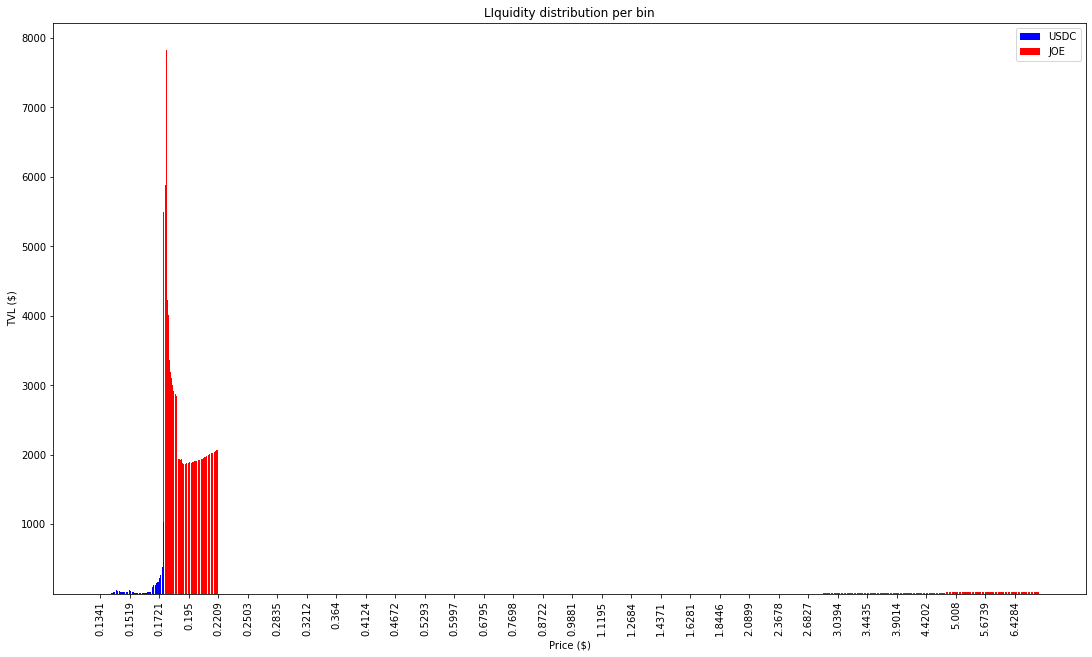

In [80]:

tick_gap = 50
# xticks = np.arange(first_bin, last_bin, 50)
# xtick_lables = np.arange(min(df.bin_price), max(df.bin_price), bin_step*50)

xticks = df.bin_id[::tick_gap]
xtick_lables = df.bin_price[::tick_gap]

fig, ax = plt.subplots()

ax.bar(list(df.bin_id), list(df.reserveY), label=tokenY_symbol, color='b', edgecolor="none")
ax.bar(list(df.bin_id), list(df.reserveX_in_Y), bottom=np.array(df.reserveY, dtype=float), label=tokenX_symbol, color='r', edgecolor="none")

ax.set_ylabel('TVL ($)')
ax.set_xlabel('Price ($)')
ax.set_title('LIquidity distribution per bin')
ax.legend()

ax.ticklabel_format(style='plain', useOffset=False)
fig.set_size_inches(18.5, 10.5, forward=True)
ax.set_xticks(xticks)
ax.set_xticklabels(np.round(xtick_lables, 4), rotation=90)
# plt.xticks(xticks, rotation=90)
plt.show()

In [83]:
df[(df['bin_price'] > 2.68)]["reserveX"].sum()

1300.1263747663477